# Mammography Report Classification with BERTimbau

**Competition:** SPR 2026 Mammography Report Classification  
**Task:** Predict BI-RADS category (0–6) from Portuguese mammography reports  
**Model:** `neuralmind/bert-base-portuguese-cased` (BERTimbau — trained on Brazilian Portuguese)

## BI-RADS Categories
| Class | Meaning |
|-------|---------|
| 0 | Incomplete — needs additional imaging |
| 1 | Negative — no abnormality |
| 2 | Benign — definitely benign finding |
| 3 | Probably benign — short-interval follow-up |
| 4 | Suspicious — tissue sampling advised |
| 5 | Highly suggestive of malignancy |
| 6 | Known biopsy-proven malignancy |

## 1. Setup & Imports

In [2]:
# Install dependencies if needed
# !pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
)

# ── Reproducibility ──────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/home/daniel/miniconda3/envs/bert_wsl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Ti


## 2. Config

In [4]:
# ── Paths ─────────────────────────────────────────────────────────────────────
DATA_DIR   = "../data"
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Model ─────────────────────────────────────────────────────────────────────
# BERTimbau: Portuguese BERT trained on BrWaC + Wikipedia PT
MODEL_NAME  = "neuralmind/bert-base-portuguese-cased"
NUM_CLASSES = 7   # BI-RADS 0–6
MAX_LEN     = 512 # Max BERT tokens (reports avg ~120 tokens, max ~400)

# ── Split ─────────────────────────────────────────────────────────────────────
TEST_SIZE = 0.20  # 20% held-out test set

# ── Training ──────────────────────────────────────────────────────────────────
N_FOLDS      = 5
EPOCHS       = 4
BATCH_SIZE   = 16
ACCUM_STEPS  = 2   # Effective batch = 32
LR           = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1
USE_CLASS_WEIGHTS = True



## 3. Data Split

Split `data.csv` into `train.csv` (80%) and `test.csv` (20%) using a **stratified** split
so that every BI-RADS class is proportionally represented in both sets.

The split files are saved to `../data/` and reused in later runs (no re-splitting).

In [5]:
data_df = pd.read_csv(f"{DATA_DIR}/data.csv")
print(f"Full dataset: {data_df.shape}")

train_df, test_df = train_test_split(
    data_df,
    test_size=TEST_SIZE,
    stratify=data_df["target"],
    random_state=SEED,
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df.to_csv(f"{DATA_DIR}/train.csv", index=False)
test_df.to_csv(f"{DATA_DIR}/test.csv",  index=False)

print(f"Train: {train_df.shape}")
print(f"Test:  {test_df.shape}")

# ── Verify class proportions are preserved ────────────────────────────────────
split_summary = pd.DataFrame({
    "Full":  data_df["target"].value_counts().sort_index(),
    "Train": train_df["target"].value_counts().sort_index(),
    "Test":  test_df["target"].value_counts().sort_index(),
})
split_summary["Train %"] = (split_summary["Train"] / split_summary["Full"] * 100).round(1)
split_summary["Test %"]  = (split_summary["Test"]  / split_summary["Full"] * 100).round(1)
print("\nClass distribution after split:")
print(split_summary)

Full dataset: (18272, 3)
Train: (14617, 3)
Test:  (3655, 3)

Class distribution after split:
         Full  Train  Test  Train %  Test %
target                                     
0         610    488   122     80.0    20.0
1         693    555   138     80.1    19.9
2       15968  12774  3194     80.0    20.0
3         713    570   143     79.9    20.1
4         214    171    43     79.9    20.1
5          29     23     6     79.3    20.7
6          45     36     9     80.0    20.0


## 4. Exploratory Data Analysis

In [6]:
train_df.head(3)

,ID,report,target
0,Acc19258,Indicação clínica:\n\r rastreamento.\n\rAchado...,2
1,Acc6749,Indicação clínica:\n\r rastreamento.\n\rAchado...,2
2,Acc19497,Indicação clínica:\n\r rastreamento.\n\rAchado...,2


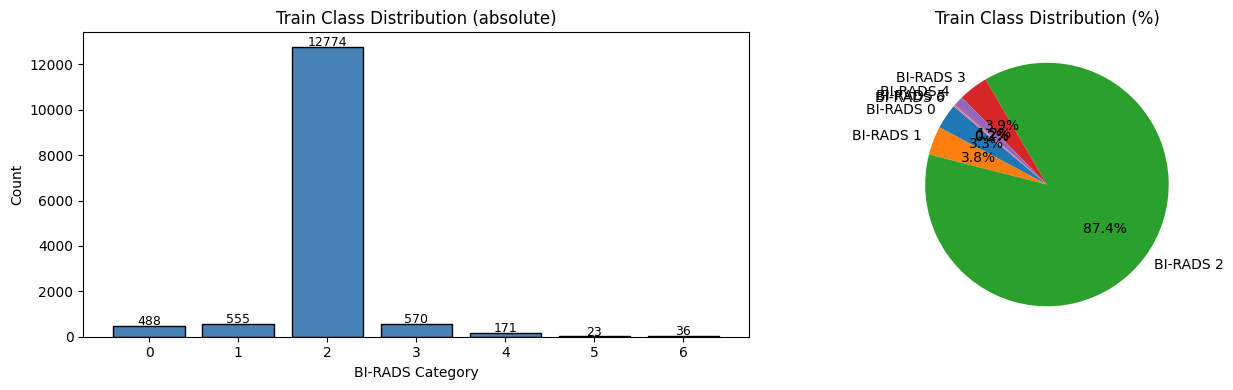


Train class counts:
target
0      488
1      555
2    12774
3      570
4      171
5       23
6       36
Name: count, dtype: int64


In [7]:
# ── Class distribution ────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

counts = train_df["target"].value_counts().sort_index()
axes[0].bar(counts.index.astype(str), counts.values, color="steelblue", edgecolor="black")
axes[0].set_xlabel("BI-RADS Category")
axes[0].set_ylabel("Count")
axes[0].set_title("Train Class Distribution (absolute)")
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 30, str(v), ha="center", fontsize=9)

axes[1].pie(counts.values, labels=[f"BI-RADS {c}" for c in counts.index],
            autopct="%1.1f%%", startangle=140)
axes[1].set_title("Train Class Distribution (%)")

plt.tight_layout()
plt.show()

print("\nTrain class counts:")
print(counts)

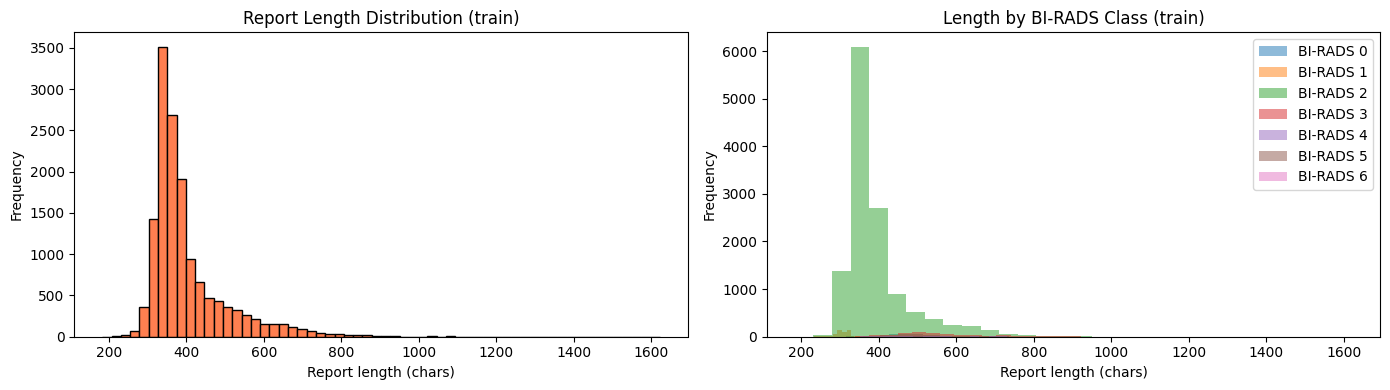

count    14617.000000
mean       400.619074
std        103.531591
min        183.000000
25%        332.000000
50%        363.000000
75%        423.000000
max       1622.000000
Name: char_len, dtype: float64


In [8]:
# ── Report length analysis ────────────────────────────────────────────────────
train_df["char_len"] = train_df["report"].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(train_df["char_len"], bins=60, color="coral", edgecolor="black")
axes[0].set_xlabel("Report length (chars)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Report Length Distribution (train)")

for cls in sorted(train_df["target"].unique()):
    subset = train_df[train_df["target"] == cls]["char_len"]
    axes[1].hist(subset, bins=30, alpha=0.5, label=f"BI-RADS {cls}")
axes[1].set_xlabel("Report length (chars)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Length by BI-RADS Class (train)")
axes[1].legend()

plt.tight_layout()
plt.show()

print(train_df["char_len"].describe())

## 5. Dataset & Tokenization

In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ── Check actual token lengths ─────────────────────────────────────────────────
sample_tokens = tokenizer(
    train_df["report"].tolist()[:500],
    truncation=False,
    return_length=True,
)["length"]
print(f"Token length stats (first 500 train samples):")
print(f"  Mean: {np.mean(sample_tokens):.0f}")
print(f"  Max:  {np.max(sample_tokens)}")
print(f"  P95:  {np.percentile(sample_tokens, 95):.0f}")
print(f"  P99:  {np.percentile(sample_tokens, 99):.0f}")
print(f"  Pct > 512: {np.mean(np.array(sample_tokens) > 512)*100:.1f}%")

Token length stats (first 500 train samples):
  Mean: 91
  Max:  475
  P95:  151
  P99:  187
  Pct > 512: 0.0%


In [10]:
class MammographyDataset(Dataset):
    """PyTorch Dataset for mammography reports."""

    def __init__(self, texts, labels=None, tokenizer=None, max_len=512):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        item = {
            "input_ids":      encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }
        if "token_type_ids" in encoding:
            item["token_type_ids"] = encoding["token_type_ids"].squeeze(0)
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

## 6. Class Weights (handle imbalance)

In [11]:
def make_balanced_class_weights(y, num_classes, device):
    """Balanced class weights: n_samples / (n_present_classes * n_class)."""
    y = np.asarray(y, dtype=np.int64)
    counts = np.bincount(y, minlength=num_classes)

    weights = np.ones(num_classes, dtype=np.float32)
    present_mask = counts > 0
    n_present = int(present_mask.sum())

    if n_present > 0:
        n_samples = int(counts[present_mask].sum())
        weights[present_mask] = n_samples / (n_present * counts[present_mask])

    return torch.tensor(weights, dtype=torch.float, device=device), counts


# Preview weights on full train split (actual training uses fold-specific weights)
class_weights_tensor, class_counts = make_balanced_class_weights(
    train_df["target"].values,
    num_classes=NUM_CLASSES,
    device=DEVICE,
)

print("Class weights preview (balanced):")
for i, w in enumerate(class_weights_tensor.cpu().numpy()):
    print(f"  BI-RADS {i}: {w:.3f}  (n={int(class_counts[i])})")



Class weights preview (balanced):
  BI-RADS 0: 4.279  (n=488)
  BI-RADS 1: 3.762  (n=555)
  BI-RADS 2: 0.163  (n=12774)
  BI-RADS 3: 3.663  (n=570)
  BI-RADS 4: 12.211  (n=171)
  BI-RADS 5: 90.789  (n=23)
  BI-RADS 6: 58.004  (n=36)


## 7. Training & Validation Functions

In [12]:
def train_epoch(model, loader, optimizer, scheduler, criterion, accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(loader, desc="Train", leave=False)):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)
        token_type_ids = batch.get("token_type_ids")
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss = criterion(outputs.logits, labels) / accum_steps
        loss.backward()

        if (step + 1) % accum_steps == 0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)


@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc="Val", leave=False):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["labels"].to(DEVICE)
        token_type_ids = batch.get("token_type_ids")
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(DEVICE)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    bal_acc  = balanced_accuracy_score(all_labels, all_preds)
    return avg_loss, bal_acc, all_labels, all_preds

## 8. Cross-Validation Training

Cross-validation runs **only on `train_df`**. The held-out `test_df` is never seen during training.

In [13]:
texts  = train_df["report"].tolist()
labels = train_df["target"].tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

oof_preds  = np.zeros((len(train_df), NUM_CLASSES))  # Out-of-fold probabilities
fold_scores = []
history     = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
    print(f"\n{'='*60}")
    print(f"  FOLD {fold+1}/{N_FOLDS}")
    print(f"{'='*60}")

    # ── Datasets ───────────────────────────────────────────────────────────────
    train_texts  = [texts[i]  for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts    = [texts[i]  for i in val_idx]
    val_labels   = [labels[i] for i in val_idx]

    train_ds = MammographyDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds   = MammographyDataset(val_texts,   val_labels,   tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE*2, shuffle=False,
                              num_workers=0, pin_memory=True)

    # ── Model ──────────────────────────────────────────────────────────────────
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
    ).to(DEVICE)

    # ── Optimizer & scheduler ──────────────────────────────────────────────────
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY
    )
    total_steps  = len(train_loader) // ACCUM_STEPS * EPOCHS
    warmup_steps = int(total_steps * WARMUP_RATIO)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    if USE_CLASS_WEIGHTS:
        fold_class_weights, fold_class_counts = make_balanced_class_weights(
            train_labels,
            num_classes=NUM_CLASSES,
            device=DEVICE,
        )
        criterion = nn.CrossEntropyLoss(weight=fold_class_weights)
        print("  Fold class weights:")
        for i, w in enumerate(fold_class_weights.cpu().numpy()):
            print(f"    BI-RADS {i}: {w:.3f}  (n={int(fold_class_counts[i])})")
    else:
        criterion = nn.CrossEntropyLoss()

    # ── Training loop ──────────────────────────────────────────────────────────
    best_val_acc  = 0
    best_model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    fold_history = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, scheduler,
                                 criterion, ACCUM_STEPS)
        val_loss, val_acc, val_true, val_pred = eval_epoch(model, val_loader, criterion)

        fold_history.append({
            "fold": fold+1, "epoch": epoch+1,
            "train_loss": train_loss, "val_loss": val_loss, "val_bal_acc": val_acc,
        })

        print(f"  Epoch {epoch+1}/{EPOCHS} — "
              f"train_loss: {train_loss:.4f}  "
              f"val_loss: {val_loss:.4f}  "
              f"val_bal_acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"    ✓ New best model saved (bal_acc={best_val_acc:.4f})")

    # ── OOF predictions from best model ───────────────────────────────────────
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.eval()

    all_oof_probs = []
    with torch.no_grad():
        for batch in DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            token_type_ids = batch.get("token_type_ids")
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            all_oof_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    oof_preds[val_idx] = np.concatenate(all_oof_probs, axis=0)
    fold_scores.append(best_val_acc)
    history.extend(fold_history)

    print(f"\n  Fold {fold+1} best balanced accuracy: {best_val_acc:.4f}")
    del model
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print(f"CV Balanced Accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"Per-fold scores: {[f'{s:.4f}' for s in fold_scores]}")





  FOLD 1/5


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 895.21it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

  Fold class weights:
    BI-RADS 0: 4.283  (n=390)
    BI-RADS 1: 3.762  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.663  (n=456)
    BI-RADS 4: 12.193  (n=137)
    BI-RADS 5: 92.802  (n=18)
    BI-RADS 6: 57.601  (n=29)


  Epoch 1/4 — train_loss: 1.1663  val_loss: 0.9031  val_bal_acc: 0.5551
    ✓ New best model saved (bal_acc=0.5551)


  Epoch 2/4 — train_loss: 0.7091  val_loss: 0.8291  val_bal_acc: 0.5443


  Epoch 3/4 — train_loss: 0.5424  val_loss: 0.8510  val_bal_acc: 0.5540


  Epoch 4/4 — train_loss: 0.4373  val_loss: 0.8147  val_bal_acc: 0.5785
    ✓ New best model saved (bal_acc=0.5785)

  Fold 1 best balanced accuracy: 0.5785

  FOLD 2/5


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 950.10it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

  Fold class weights:
    BI-RADS 0: 4.283  (n=390)
    BI-RADS 1: 3.762  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.663  (n=456)
    BI-RADS 4: 12.193  (n=137)
    BI-RADS 5: 92.802  (n=18)
    BI-RADS 6: 57.601  (n=29)


  Epoch 1/4 — train_loss: 1.2050  val_loss: 0.9113  val_bal_acc: 0.4887
    ✓ New best model saved (bal_acc=0.4887)


  Epoch 2/4 — train_loss: 0.6734  val_loss: 0.9198  val_bal_acc: 0.5342
    ✓ New best model saved (bal_acc=0.5342)


  Epoch 3/4 — train_loss: 0.4829  val_loss: 0.7000  val_bal_acc: 0.6283
    ✓ New best model saved (bal_acc=0.6283)


  Epoch 4/4 — train_loss: 0.3655  val_loss: 0.7357  val_bal_acc: 0.6098

  Fold 2 best balanced accuracy: 0.6283

  FOLD 3/5


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 922.62it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

  Fold class weights:
    BI-RADS 0: 4.273  (n=391)
    BI-RADS 1: 3.763  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.664  (n=456)
    BI-RADS 4: 12.194  (n=137)
    BI-RADS 5: 87.925  (n=19)
    BI-RADS 6: 59.663  (n=28)


  Epoch 1/4 — train_loss: 1.1805  val_loss: 0.8253  val_bal_acc: 0.5391
    ✓ New best model saved (bal_acc=0.5391)


  Epoch 2/4 — train_loss: 0.6410  val_loss: 0.6443  val_bal_acc: 0.6549
    ✓ New best model saved (bal_acc=0.6549)


  Epoch 3/4 — train_loss: 0.4501  val_loss: 0.6094  val_bal_acc: 0.6860
    ✓ New best model saved (bal_acc=0.6860)


  Epoch 4/4 — train_loss: 0.3552  val_loss: 0.6389  val_bal_acc: 0.6844

  Fold 3 best balanced accuracy: 0.6860

  FOLD 4/5


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 930.82it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

  Fold class weights:
    BI-RADS 0: 4.273  (n=391)
    BI-RADS 1: 3.763  (n=444)
    BI-RADS 2: 0.163  (n=10219)
    BI-RADS 3: 3.664  (n=456)
    BI-RADS 4: 12.284  (n=136)
    BI-RADS 5: 87.925  (n=19)
    BI-RADS 6: 57.606  (n=29)


  Epoch 1/4 — train_loss: 1.1783  val_loss: 0.9348  val_bal_acc: 0.5084
    ✓ New best model saved (bal_acc=0.5084)


  Epoch 2/4 — train_loss: 0.6581  val_loss: 0.7872  val_bal_acc: 0.5798
    ✓ New best model saved (bal_acc=0.5798)


  Epoch 3/4 — train_loss: 0.4611  val_loss: 0.7388  val_bal_acc: 0.6902
    ✓ New best model saved (bal_acc=0.6902)


  Epoch 4/4 — train_loss: 0.3726  val_loss: 0.7438  val_bal_acc: 0.7610
    ✓ New best model saved (bal_acc=0.7610)

  Fold 4 best balanced accuracy: 0.7610

  FOLD 5/5


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 914.50it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

  Fold class weights:
    BI-RADS 0: 4.284  (n=390)
    BI-RADS 1: 3.763  (n=444)
    BI-RADS 2: 0.163  (n=10220)
    BI-RADS 3: 3.664  (n=456)
    BI-RADS 4: 12.194  (n=137)
    BI-RADS 5: 92.810  (n=18)
    BI-RADS 6: 57.606  (n=29)


  Epoch 1/4 — train_loss: 1.1814  val_loss: 0.8400  val_bal_acc: 0.5210
    ✓ New best model saved (bal_acc=0.5210)


  Epoch 2/4 — train_loss: 0.6298  val_loss: 0.6664  val_bal_acc: 0.5968
    ✓ New best model saved (bal_acc=0.5968)


  Epoch 3/4 — train_loss: 0.4604  val_loss: 0.6821  val_bal_acc: 0.5998
    ✓ New best model saved (bal_acc=0.5998)


  Epoch 4/4 — train_loss: 0.3713  val_loss: 0.6832  val_bal_acc: 0.5962

  Fold 5 best balanced accuracy: 0.5998

CV Balanced Accuracy: 0.6507 ± 0.0659
Per-fold scores: ['0.5785', '0.6283', '0.6860', '0.7610', '0.5998']


## 9. OOF Evaluation (Cross-Validation)

In [14]:
oof_labels = train_df["target"].values
oof_pred_classes = oof_preds.argmax(axis=1)

print("OOF Classification Report:")
print(classification_report(
    oof_labels, oof_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

bal_acc = balanced_accuracy_score(oof_labels, oof_pred_classes)
print(f"OOF Balanced Accuracy: {bal_acc:.4f}")

OOF Classification Report:
              precision    recall  f1-score   support

   BI-RADS 0       0.74      0.87      0.80       488
   BI-RADS 1       0.90      0.98      0.94       555
   BI-RADS 2       0.99      0.96      0.97     12774
   BI-RADS 3       0.47      0.70      0.56       570
   BI-RADS 4       0.54      0.57      0.56       171
   BI-RADS 5       0.33      0.13      0.19        23
   BI-RADS 6       0.60      0.33      0.43        36

    accuracy                           0.94     14617
   macro avg       0.65      0.65      0.64     14617
weighted avg       0.95      0.94      0.94     14617

OOF Balanced Accuracy: 0.6489


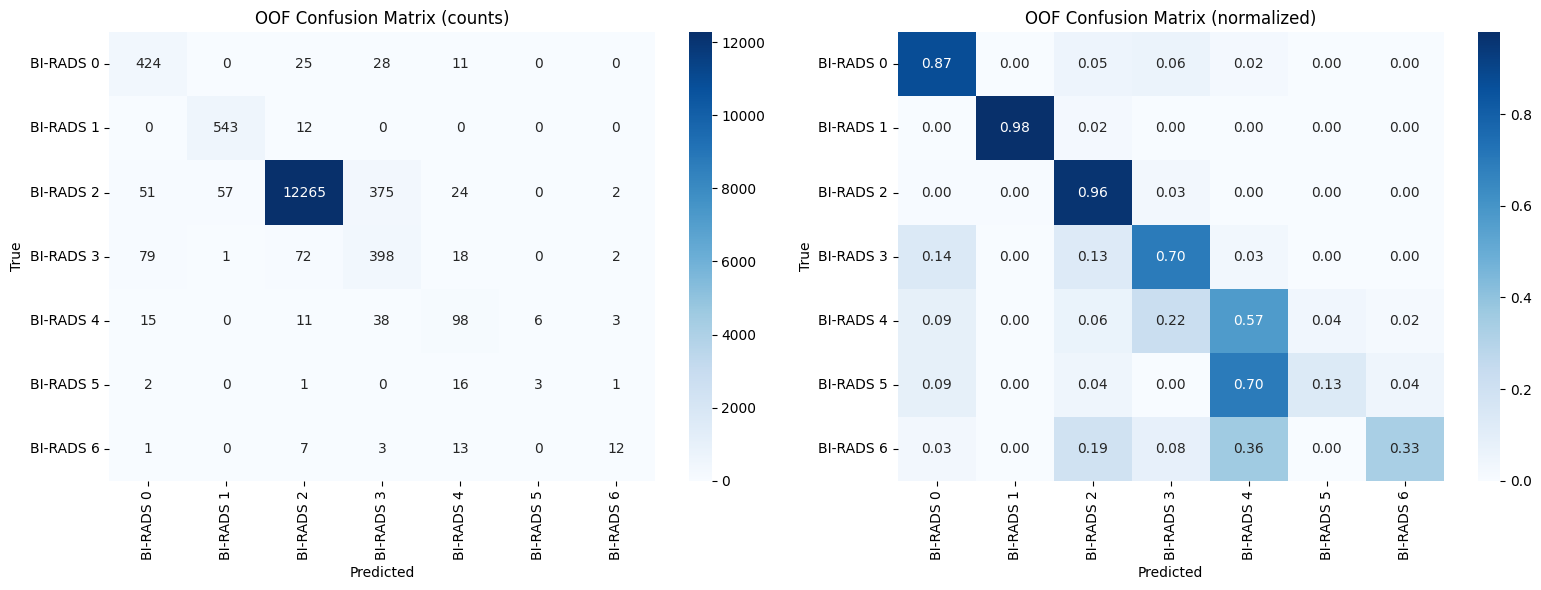

In [15]:
# Confusion matrix
cm = confusion_matrix(oof_labels, oof_pred_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm,      "OOF Confusion Matrix (counts)",     "d"),
    (axes[1], cm_norm, "OOF Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Blues", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

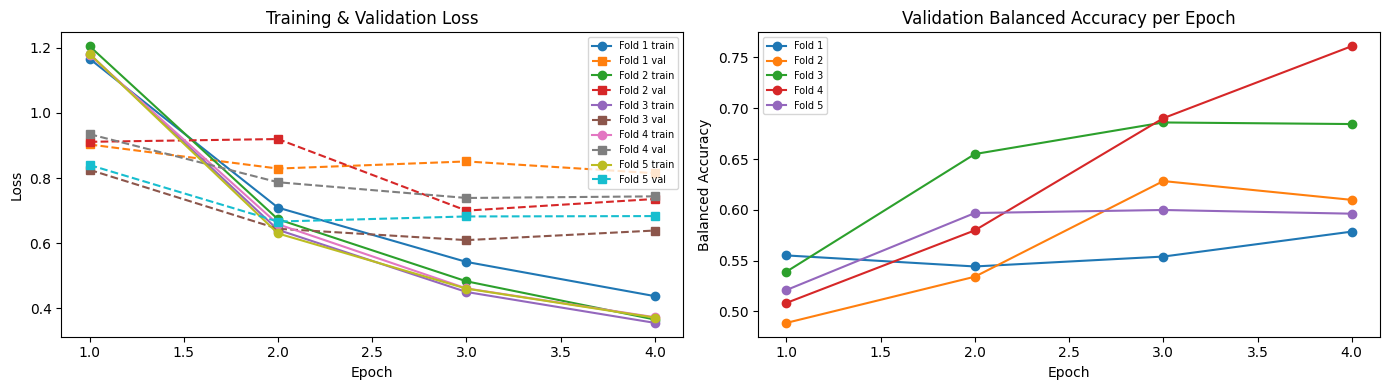

In [16]:
# Training curves
hist_df = pd.DataFrame(history)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for fold_id in range(1, N_FOLDS+1):
    fd = hist_df[hist_df["fold"] == fold_id]
    axes[0].plot(fd["epoch"], fd["train_loss"], marker="o", label=f"Fold {fold_id} train")
    axes[0].plot(fd["epoch"], fd["val_loss"],   marker="s", linestyle="--", label=f"Fold {fold_id} val")
    axes[1].plot(fd["epoch"], fd["val_bal_acc"], marker="o", label=f"Fold {fold_id}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend(fontsize=7)

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Balanced Accuracy")
axes[1].set_title("Validation Balanced Accuracy per Epoch")
axes[1].legend(fontsize=7)

plt.tight_layout()
plt.show()

## 10. Inference & Evaluation on Held-Out Test Set

Ensemble all fold models by averaging their softmax probabilities, then evaluate
against the ground-truth labels in `test_df`.

In [17]:
test_texts  = test_df["report"].tolist()
test_labels = test_df["target"].tolist()

test_ds     = MammographyDataset(test_texts, labels=test_labels, tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

test_preds = np.zeros((len(test_df), NUM_CLASSES))

for fold in range(N_FOLDS):
    model_path = f"{OUTPUT_DIR}/best_fold{fold+1}.pt"
    if not os.path.exists(model_path):
        print(f"Skipping fold {fold+1} — model not found")
        continue

    print(f"Fold {fold+1}: loading {model_path}")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    fold_probs = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Fold {fold+1} inference", leave=False):
            input_ids      = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            token_type_ids = batch.get("token_type_ids")
            if token_type_ids is not None:
                token_type_ids = token_type_ids.to(DEVICE)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            fold_probs.append(torch.softmax(outputs.logits, dim=-1).cpu().numpy())

    test_preds += np.concatenate(fold_probs, axis=0)
    del model
    torch.cuda.empty_cache()

# Average over folds
test_preds /= N_FOLDS
test_pred_classes = test_preds.argmax(axis=1)

Fold 1: loading ./outputs/best_fold1.pt


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 916.43it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

Fold 2: loading ./outputs/best_fold2.pt


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 938.46it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

Fold 3: loading ./outputs/best_fold3.pt


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 927.26it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

Fold 4: loading ./outputs/best_fold4.pt


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 932.98it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

Fold 5: loading ./outputs/best_fold5.pt


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 951.02it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: neuralmind/bert-base-portuguese-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from differ

In [18]:
# ── Test set evaluation metrics ───────────────────────────────────────────────
test_true = np.array(test_labels)

print("Test Set Classification Report:")
print(classification_report(
    test_true, test_pred_classes,
    target_names=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
))

test_bal_acc = balanced_accuracy_score(test_true, test_pred_classes)
print(f"Test Balanced Accuracy: {test_bal_acc:.4f}")
print(f"\nSummary:")
print(f"  OOF  Balanced Accuracy: {balanced_accuracy_score(oof_labels, oof_pred_classes):.4f}")
print(f"  Test Balanced Accuracy: {test_bal_acc:.4f}")

Test Set Classification Report:
              precision    recall  f1-score   support

   BI-RADS 0       0.79      0.88      0.83       122
   BI-RADS 1       0.86      0.97      0.91       138
   BI-RADS 2       0.99      0.96      0.98      3194
   BI-RADS 3       0.51      0.74      0.60       143
   BI-RADS 4       0.64      0.67      0.66        43
   BI-RADS 5       0.00      0.00      0.00         6
   BI-RADS 6       0.67      0.22      0.33         9

    accuracy                           0.95      3655
   macro avg       0.64      0.64      0.62      3655
weighted avg       0.95      0.95      0.95      3655

Test Balanced Accuracy: 0.6356

Summary:
  OOF  Balanced Accuracy: 0.6489
  Test Balanced Accuracy: 0.6356


/home/daniel/miniconda3/envs/bert_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daniel/miniconda3/envs/bert_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daniel/miniconda3/envs/bert_wsl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

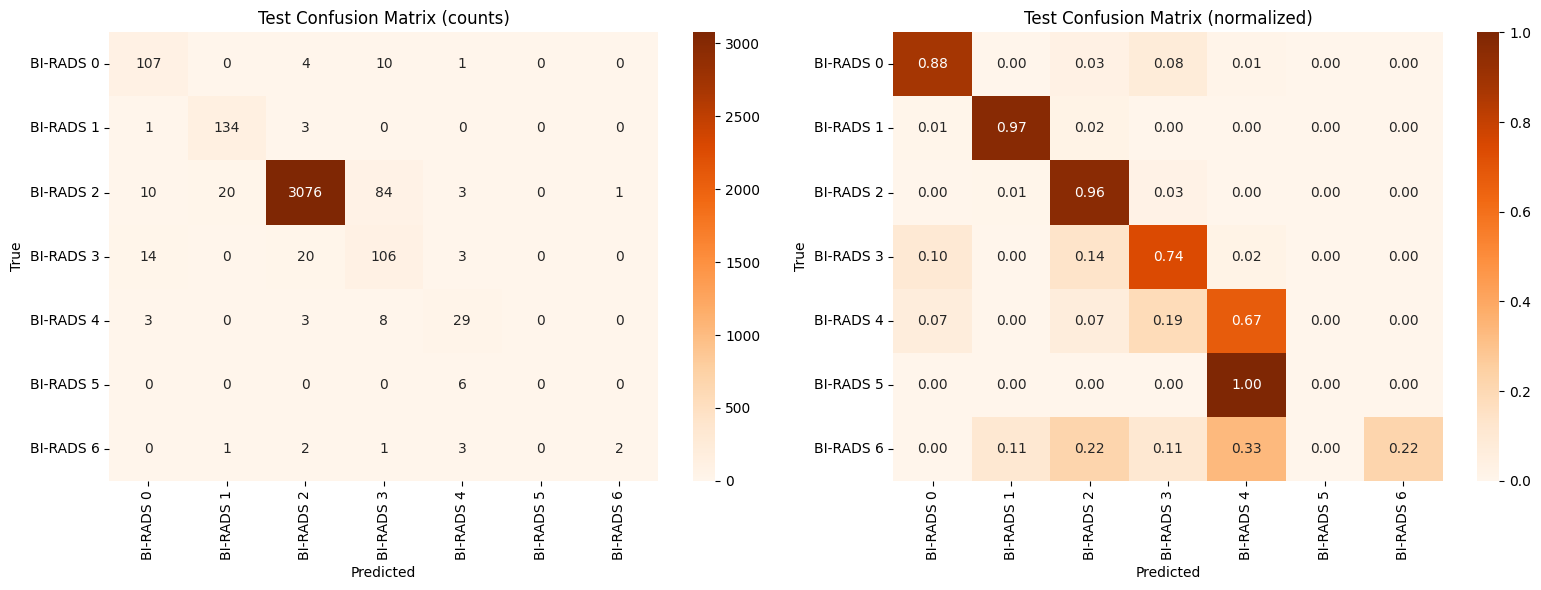

In [19]:
# ── Test confusion matrix ─────────────────────────────────────────────────────
cm_test      = confusion_matrix(test_true, test_pred_classes)
cm_test_norm = cm_test.astype(float) / cm_test.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, data, title, fmt in [
    (axes[0], cm_test,      "Test Confusion Matrix (counts)",     "d"),
    (axes[1], cm_test_norm, "Test Confusion Matrix (normalized)", ".2f"),
]:
    sns.heatmap(data, annot=True, fmt=fmt, cmap="Oranges", ax=ax,
                xticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)],
                yticklabels=[f"BI-RADS {i}" for i in range(NUM_CLASSES)])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 11. Save Predictions

In [20]:
# ── Test predictions with ground truth ────────────────────────────────────────
test_results = test_df[["ID", "target"]].copy()
test_results["predicted"] = test_pred_classes
test_results["correct"]   = test_results["target"] == test_results["predicted"]
for i in range(NUM_CLASSES):
    test_results[f"prob_class_{i}"] = test_preds[:, i]

test_results.to_csv(f"{OUTPUT_DIR}/test_predictions.csv", index=False)
print(f"Test predictions saved to {OUTPUT_DIR}/test_predictions.csv")
print(f"Overall accuracy: {test_results['correct'].mean()*100:.2f}%")
test_results.head(10)

Test predictions saved to ./outputs/test_predictions.csv
Overall accuracy: 94.50%


,ID,target,predicted,correct,prob_class_0,prob_class_1,prob_class_2,prob_class_3,prob_class_4,prob_class_5,prob_class_6
0,Acc8052,2,2,True,0.000817,0.001119,0.993838,0.001529,0.000620,0.000761,0.001315
1,Acc13753,2,2,True,0.001163,0.001084,0.993845,0.001352,0.000610,0.000761,0.001185
2,Acc4514,2,2,True,0.000944,0.001108,0.994079,0.001471,0.000562,0.000711,0.001125
3,Acc12396,2,2,True,0.000896,0.001063,0.994121,0.001466,0.000571,0.000725,0.001159
4,Acc22659,2,1,False,0.001322,0.682615,0.305872,0.003282,0.001335,0.002317,0.003256
5,Acc22473,2,2,True,0.000910,0.001114,0.994071,0.001439,0.000576,0.000729,0.001161
6,Acc11889,2,2,True,0.000896,0.001125,0.994097,0.001429,0.000576,0.000722,0.001156
7,Acc4700,0,0,True,0.914544,0.001611,0.015584,0.056467,0.005352,0.003725,0.002717
8,Acc10650,2,2,True,0.000829,0.001204,0.994103,0.001394,0.000573,0.000721,0.001175
9,Acc16931,2,2,True,0.357404,0.002205,0.577505,0.034162,0.012966,0.008044,0.007714


In [21]:
# ── OOF predictions for stacking / further analysis ───────────────────────────
oof_df = pd.DataFrame(
    oof_preds,
    columns=[f"prob_class_{i}" for i in range(NUM_CLASSES)]
)
oof_df.insert(0, "ID",        train_df["ID"].values)
oof_df.insert(1, "target",    train_df["target"].values)
oof_df.insert(2, "predicted", oof_pred_classes)
oof_df.to_csv(f"{OUTPUT_DIR}/oof_predictions.csv", index=False)
print("OOF predictions saved.")

OOF predictions saved.
